In [1]:
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

Python implementation: CPython
Python version       : 3.7.4
IPython version      : 7.8.0

numpy      : 1.17.2
scipy      : 1.4.1
pandas     : 1.0.3
matplotlib : 3.2.1
statsmodels: 0.11.1
sklearn    : 0.21.3

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-62-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Git hash: 77dafa42a619730d84e03949ac152177b92bb669



In [3]:
import os
import pickle
import pandas as pd
import numpy as np
import itertools
import warnings
#from tqdm.notebook import tqdm
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.model_selection import learning_curve

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC

In [6]:
PATH_TO_DATA = './my_data'
ANSW = './answers'

In [7]:
def write_answer_to_file(answer, file_address):
    if isinstance(answer, list) or isinstance(answer, np.ndarray):
        with open(os.path.join(ANSW, file_address), 'w') as out_f:
            for idx, elmnt in enumerate(answer):
                if idx == 0:
                    out_f.write(str(elmnt))
                else:
                    out_f.write(' ' + str(elmnt))
    else:
        with open(os.path.join(ANSW, file_address), 'w') as out_f:
            out_f.write(str(answer))

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

In [8]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sp_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

X_sparse_10users.shape

(14061, 4913)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [12]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    #valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    #valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    #plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
    #                 facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

KNeighborsClassifier

In [13]:
def get_metrics(inp_clf, inp_skf, inp_x_tr, inp_y_tr, inp_x_val, inp_y_val):
    acc_cv = []
    acc_val = 0
    
    for train_index, test_index in skf.split(inp_x_tr, inp_y_tr):
        clf = inp_clf
        clf.fit(inp_x_tr[train_index], inp_y_tr[train_index])
        predicted = clf.predict(inp_x_tr[test_index])
        acc_cv.append(accuracy_score(inp_y_tr[test_index], predicted))
        #print('Score: ', clf.score(inp_x_tr[test_index], inp_y_tr[test_index]))
    
    clf = inp_clf
    clf.fit(inp_x_tr, inp_y_tr)

    predicted = clf.predict(inp_x_val)
    acc_val = accuracy_score(inp_y_val, predicted)

    return acc_cv, acc_val

In [14]:
answ1_1, answ1_2 = get_metrics(KNeighborsClassifier(n_neighbors=100, n_jobs=-1), skf, X_train, y_train, X_valid, y_valid)

In [15]:
answ1 = [round(np.mean(answ1_1), 2), round(answ1_2, 2)]
answ1

[0.56, 0.58]

RandomForestClassifier

In [16]:
clfRF = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, random_state=17)

In [17]:
oob_score, acc_rf = get_metrics(clfRF, skf, X_train, y_train, X_valid, y_valid)
oob_score, acc_rf

([0.7214611872146118, 0.7136322049405307, 0.714765100671141],
 0.7312159279450107)

In [18]:
answ2 = [round(np.mean(oob_score), 2), round(acc_rf, 2)]
answ2

[0.72, 0.73]

In [19]:
write_answer_to_file(answ2, 'answer4_2.txt')

LogisticRegression

In [20]:
clfLR = LogisticRegression(random_state=17, n_jobs=-1)

In [21]:
acc_cv_lr, acc_lr = get_metrics(clfLR, skf, X_train, y_train, X_valid, y_valid)
acc_cv_lr, acc_lr

/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


([0.7622526636225266, 0.7605977432143947, 0.7647956070774863],
 0.7817018250770325)

In [22]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs = logit_c_values1, multi_class='multinomial'
                                            , cv = skf, random_state=17, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 3.85 s, sys: 113 ms, total: 3.96 s
Wall time: 7.98 s


/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=-1, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [23]:
def get_metrics_v2(inp_logit_c_values, inp_logit_grid_searcher):

    ret_df = pd.DataFrame(index = inp_logit_c_values, columns = [])

    score_list = []
    # class
    for idx, el in enumerate(list(inp_logit_grid_searcher.scores_.values())):
        ret_df['class' + str(idx) + str(0)] = el[0]
        ret_df['class' + str(idx) + str(1)] = el[1]
        ret_df['class' + str(idx) + str(2)] = el[2]

    ret_df['mean_train_score'] = ret_df.mean(axis = 1)
    ret_df['std_train_score'] = ret_df.std(axis = 1)
    
    return ret_df

In [24]:
df = get_metrics_v2(logit_c_values1, logit_grid_searcher1)
df[['mean_train_score', 'std_train_score']]

,mean_train_score,std_train_score
0.000100,0.316799,0.007629
0.000464,0.473586,0.004157
0.002154,0.554767,0.002035
0.010000,0.648551,0.006874
0.046416,0.715507,0.002683
0.215443,0.750054,0.003652
1.000000,0.760923,0.001994
4.641589,0.762549,0.001234
21.544347,0.756451,0.001824
100.000000,0.744871,0.005548


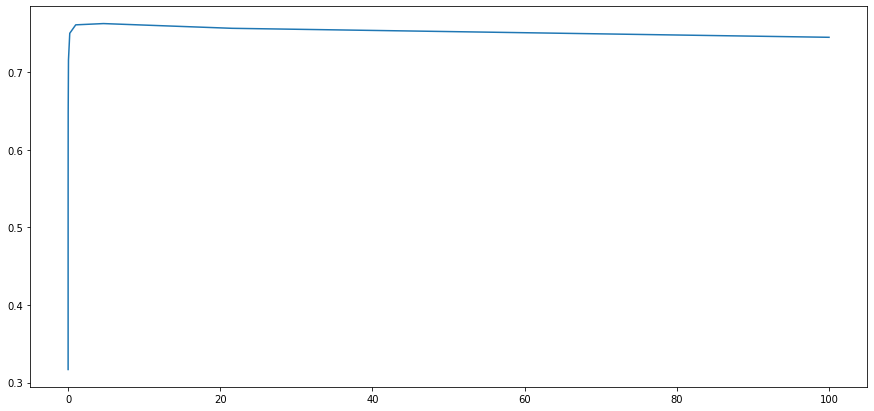

In [25]:
plt.figure(figsize = (15, 7))
plt.plot(logit_grid_searcher1.Cs_, df['mean_train_score']);

In [26]:
print(max(df['mean_train_score']))
print(df[df['mean_train_score'] == max(df['mean_train_score'])].index)

0.7625486092810018
Float64Index([4.641588833612772], dtype='float64')


In [27]:
%%time
logit_c_values2 = np.logspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs = logit_c_values2, multi_class='multinomial'
                                            , cv = skf, random_state=17, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

df2 = get_metrics_v2(logit_c_values2, logit_grid_searcher2)
df2[['mean_train_score', 'std_train_score']]

CPU times: user 3.99 s, sys: 50.1 ms, total: 4.04 s
Wall time: 21.2 s


/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


,mean_train_score,std_train_score
1.258925e+00,0.762956,0.003246
2.905079e+00,0.763768,0.001727
6.703719e+00,0.761330,0.000961
1.546941e+01,0.756553,0.000377
3.569699e+01,0.752490,0.001641
8.237387e+01,0.744971,0.003488
1.900848e+02,0.742939,0.004079
4.386370e+02,0.740196,0.003332
1.012193e+03,0.740095,0.002855
2.335721e+03,0.737352,0.002371


In [28]:
print(max(df2['mean_train_score']))
print(df2[df2['mean_train_score'] == max(df2['mean_train_score'])].index)

0.7637679367638022
Float64Index([2.9050786505108603], dtype='float64')


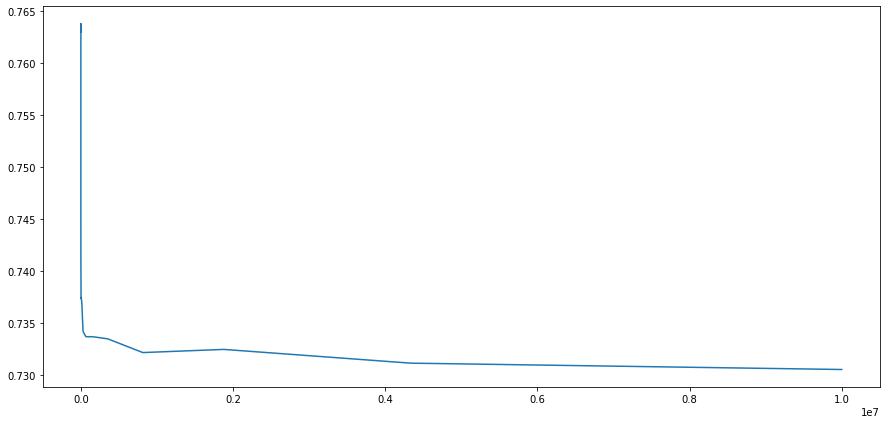

In [29]:
plt.figure(figsize = (15, 7))
plt.plot(logit_grid_searcher2.Cs_, df2['mean_train_score']);

In [30]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.7798056411471913

In [31]:
answ3 = [round(max(df2['mean_train_score']), 2), round(logit_cv_acc, 2)]
answ3

[0.76, 0.78]

In [32]:
write_answer_to_file(answ3, 'answer4_3.txt')

LinearSVC

In [31]:
clf_inp = LinearSVC(C = 1, random_state = 17)
acc_cv, acc_val = get_metrics(clf_inp, skf, X_train, y_train, X_valid, y_valid)
acc_cv, acc_val

/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


([0.7567732115677321, 0.7532784385483379, 0.7593044539353264],
 0.7769613652524295)

In [32]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(LinearSVC(random_state = 17), svm_params1, n_jobs=-1, return_train_score = True)
svm_grid_searcher1.fit(X_train, y_train)

/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 2.53 s, sys: 11.7 ms, total: 2.54 s
Wall time: 14.8 s


/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [33]:
print(svm_grid_searcher1.best_score_)
print(svm_grid_searcher1.best_params_)

0.6848201585043691
{'C': 7777.777800000001}


In [34]:
print(max(svm_grid_searcher1.cv_results_['mean_train_score']))
print(svm_grid_searcher1.cv_results_['mean_train_score'][7])
print(svm_grid_searcher1.cv_results_['params'][7])

0.8755810871118718
0.8755810871118718
{'C': 7777.777800000001}


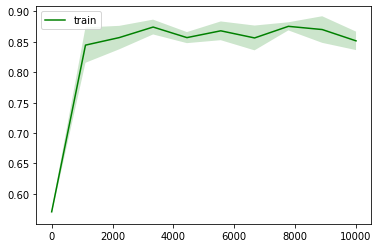

In [35]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

In [36]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(LinearSVC(random_state = 17), svm_params2, n_jobs=-1, return_train_score = True)
svm_grid_searcher2.fit(X_train, y_train)

/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 767 ms, sys: 19.7 ms, total: 786 ms
Wall time: 24.1 s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [37]:
print(svm_grid_searcher2.best_score_)
print(list(svm_grid_searcher2.best_params_.values())[0])

0.7661044503149766
0.13879310344827586


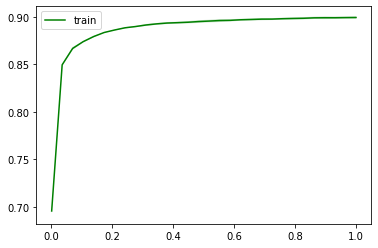

In [38]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

In [39]:
clfSVC = LinearSVC(C = list(svm_grid_searcher2.best_params_.values())[0], random_state=17)
clfSVC.fit(X_train, y_train)
svm_cv_acc = accuracy_score(y_valid, clfSVC.predict(X_valid))
svm_cv_acc

0.7817018250770325

In [40]:
print(max(svm_grid_searcher2.cv_results_['mean_train_score']))
print(svm_grid_searcher2.cv_results_['mean_train_score'][4])
print(svm_grid_searcher2.cv_results_['params'][4])

0.8993599000817655
0.8792925829596715
{'C': 0.13879310344827586}


In [41]:
svc_acc_cv, svc_acc_val = get_metrics(LinearSVC(C = list(svm_grid_searcher2.best_params_.values())[0], random_state = 17), skf, X_train, y_train, X_valid, y_valid)
svc_acc_cv, svc_acc_val

([0.7649923896499239, 0.7615126562976517, 0.7660158633312996],
 0.7817018250770325)

In [42]:
answ4_4_2 = svc_acc_val

In [43]:
answ4_4_1 = np.mean(svc_acc_cv)#svm_cv_acc#accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))

In [44]:
answ4_4 = [round(answ4_4_1, 2), round(answ4_4_2, 2)]
answ4_4

[0.76, 0.78]

In [45]:
write_answer_to_file(answ4_4, 'answer4_4.txt')

# Часть 2. Выбор параметров – длины сессии и ширины окна

In [46]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as X_pkl:
        X_inner = pickle.load(X_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y_inner = pickle.load(y_pkl)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_inner, y_inner, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y_inner)
    #skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    ret_acc_cv = []
    #for train_index, test_index in skf.split(X_train, y_train):
    for train_index, test_index in cv.split(X_train, y_train):
        clf = estimator
        clf.fit(X_train[train_index], y_train[train_index])
        predicted = clf.predict(X_train[test_index])
        ret_acc_cv.append(accuracy_score(y_train[test_index], predicted))
        
    clf = estimator
    clf.fit(X_train, y_train)
    ret_acc_val = accuracy_score(y_valid, clf.predict(X_valid))
    
    return np.mean(ret_acc_cv), ret_acc_val

In [47]:
model_assessment(svm_grid_searcher2.best_estimator_
                 , os.path.join(PATH_TO_DATA, 'X_sp_10users.pkl')
                 , os.path.join(PATH_TO_DATA, 'y_10users.pkl')
                 , skf, random_state=17, test_size=0.3)

(0.7641736364262918, 0.7817018250770325)

In [48]:
%%time
estm = svm_grid_searcher2.best_estimator_
skf  = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
results = {}

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        #path_to_y_pkl = os.path.join(PATH_TO_DATA, f'Y_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, f'Y_sparse_10users_s{session_length}_w{window_size}.pkl')
        #print(path_to_X_pkl)
        acc_cv, acc_val = model_assessment(svm_grid_searcher2.best_estimator_ 
                         , path_to_X_pkl
                         , path_to_y_pkl 
                         , cv = skf, random_state=17, test_size=0.3)
        results[f's{session_length}_w{window_size}'] = (acc_cv, acc_val)

/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CPU times: user 29.5 s, sys: 16.7 ms, total: 29.5 s
Wall time: 29.6 s


In [49]:
results

{'s15_w10': (0.8259531982725311, 0.8400094809196492),
 's10_w10': (0.7641736364262918, 0.7817018250770325),
 's15_w7': (0.8504951852074757, 0.8544881367181019),
 's10_w7': (0.8001385385477496, 0.8075327692052431),
 's7_w7': (0.7512069688975528, 0.7629002820640451),
 's15_w5': (0.8706948653050466, 0.8764817449027975),
 's10_w5': (0.816431449231953, 0.8253911806543386),
 's7_w5': (0.773092677463695, 0.7871028923660502),
 's5_w5': (0.7230970052618901, 0.7367235656709341)}

In [50]:
answ4_5_1 = results['s15_w5'][0]
answ4_5_2 = results['s15_w5'][1]
answ4_5_1, answ4_5_2

(0.8706948653050466, 0.8764817449027975)

In [51]:
answ4_5 = [round(answ4_5_1, 2), round(answ4_5_2, 2)]
answ4_5

[0.87, 0.88]

In [52]:
write_answer_to_file(answ4_5, 'answer4_5.txt')

In [63]:
%%time
estm = svm_grid_searcher2.best_estimator_
skf  = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
results150 = {}

for window_size, session_length in tqdm(itertools.product([10, 7, 5], [15, 10, 7, 5])):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_150users_s{session_length}_w{window_size}.pkl')
        #path_to_y_pkl = os.path.join(PATH_TO_DATA, f'Y_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, f'Y_sparse_150users_s{session_length}_w{window_size}.pkl')
        #print(path_to_X_pkl)
        acc_cv, acc_val = model_assessment(svm_grid_searcher2.best_estimator_ 
                         , path_to_X_pkl
                         , path_to_y_pkl 
                         , cv = skf, random_state=17, test_size=0.3)
        results150[f's{session_length}_w{window_size}'] = (acc_cv, acc_val)

0it [00:00, ?it/s]/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
2it [09:18, 306.12s/it]/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
7it [28:31, 275.23s/it]/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
12it [1:01:05, 305.43s/it]

CPU times: user 1h 1min 21s, sys: 1.49 s, total: 1h 1min 22s
Wall time: 1h 1min 5s


In [64]:
results150

{'s15_w10': (0.550363371512566, 0.5766798034350217),
 's10_w10': (0.4616145225656354, 0.48447915146207365),
 's15_w7': (0.5842562089277951, 0.6113022447797799),
 's10_w7': (0.502628509268666, 0.5261266478182376),
 's7_w7': (0.4374078763743305, 0.45415062847021154),
 's15_w5': (0.6165801657473978, 0.6391930695478659),
 's10_w5': (0.5275663749787812, 0.5487905776999076),
 's7_w5': (0.46695200044261503, 0.4830510536818027),
 's5_w5': (0.4093985555889958, 0.42267727648805176)}

Как мы видим в обоих выриантах лучшее решение с самой длинной сессией.    
Ширина окна скорее всего сказывается на объеме сессий в обучающей выборке.

In [65]:
answ4_6_1, answ4_6_2 = results150['s10_w10']

In [66]:
answ4_6 = [round(answ4_6_1, 2), round(answ4_6_2, 2)]
answ4_6

[0.46, 0.48]

In [67]:
write_answer_to_file(answ4_6, 'answer4_6.txt')

# Часть 3. Идентификация  конкретного пользователя и кривые обучения

In [68]:
with open(os.path.join(PATH_TO_DATA, 'X_sp_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)
    
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

In [114]:
%%time
warnings.filterwarnings('ignore')

logit_cv_150users = LogisticRegressionCV(Cs =[logit_grid_searcher2.Cs_[10]], multi_class='ovr'
                                            , cv = skf, random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

warnings.filterwarnings('default')

CPU times: user 9min 21s, sys: 7.97 s, total: 9min 29s
Wall time: 4min 24s


In [127]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = np.mean([float(logit_cv_150users.scores_[user_id][0])\
                                        , float(logit_cv_150users.scores_[user_id][1])\
                                        , float(logit_cv_150users.scores_[user_id][2])]
                                        , axis = 0
                                        )
    print(f'User {user_id}, CV score: {cv_scores_by_user[user_id]}')

User 6, CV score: 0.9959438402938933
User 13, CV score: 0.9965075294693774
User 15, CV score: 0.9950161882777585
User 16, CV score: 0.9912525885634165
User 28, CV score: 0.9904598628032559
User 31, CV score: 0.9934214717926885
User 33, CV score: 0.9932752620272175
User 39, CV score: 0.9855288590840804
User 46, CV score: 0.997789732638407
User 49, CV score: 0.9948913550321911
User 50, CV score: 0.993817742188117
User 53, CV score: 0.9933063099001623
User 65, CV score: 0.9964131387926516
User 66, CV score: 0.9942655594826375
User 82, CV score: 0.995871345368068
User 85, CV score: 0.9960692551173956
User 89, CV score: 0.9894385766030759
User 92, CV score: 0.9941405209595006
User 100, CV score: 0.9939633059333784
User 102, CV score: 0.9912208113418622
User 103, CV score: 0.9808686140363952
User 105, CV score: 0.9967994250288541
User 106, CV score: 0.9946728615061756
User 118, CV score: 0.9910855440879641
User 119, CV score: 0.9964760815698988
User 120, CV score: 0.9936296436790316
User 126

разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью LogisticRegressionCV) и 
долей меток в y_train_150, отличных от ID этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером 𝑖 в задаче классификации 𝑖-vs-All).

In [137]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []

for user_id in np.unique(y_train_150):
    same = 0
    for el in y_train_150:
        if el == user_id:
            same += 1
            
    #print(1 - same/y_train_150.shape[0])
    acc_diff_vs_constant.append(cv_scores_by_user[user_id] - (1 - same/y_train_150.shape[0]))

In [138]:
num_better_than_default = (np.array(acc_diff_vs_constant) > 0).sum()
num_better_than_default

87

In [130]:
answ4_7 = round(1 - num_better_than_default/len(np.unique(y_train_150)), 2)
answ4_7

0.42

In [121]:
write_answer_to_file(answ4_7, 'answer4_7.txt')

In [154]:
y_binary_128 = [int(el == 128) for el in y_train_150]

In [156]:
sum(y_binary_128)

1957

In [158]:
def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

In [159]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_train_150, y_train_150,
                                             train_sizes = train_sizes
                                             , cv = skf, random_state=om_state = 17
                                             , n_jobs = -1
                                             )

/home/voloch/Anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 24min 34s, sys: 2.2 s, total: 24min 36s
Wall time: 24min 37s


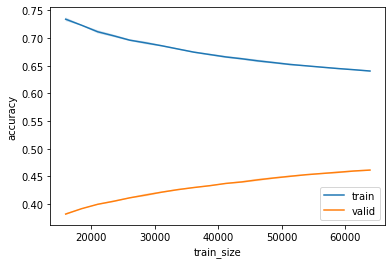

In [160]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')